In [3]:
!pip install requests pandas python-dotenv spacy wordcloud
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.1 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [26]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cleaned-csv/jira_issues_cleaned.csv")
df.head()

,input_text,priority_level
0,update command usage NNThroughputBenchmark add...,Medium
1,Upgrade esdk obs java esdk obs java dependency...,Medium
2,improve error message path contain double slas...,Low
3,Insert Overwrite Jobs MagicCommitter fail Expr...,Medium
4,abfs fnsoverblob add distinct string User Agen...,Medium


**Define Inputs (X) and Labels (y)**

In [27]:
X = df["input_text"]
y = df["priority_level"]

**Split the Dataset**

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Convert Text to Vectors (TF-IDF)**

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary size
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english" # filter English stopwords
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Train a Classifier (Naive Bayes)

In [36]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.63      0.03      0.06       359
         Low       0.59      0.08      0.14       865
      Medium       0.66      0.98      0.79      2229

    accuracy                           0.65      3453
   macro avg       0.63      0.36      0.33      3453
weighted avg       0.64      0.65      0.55      3453



In [55]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight="balanced")
svm_model.fit(X_train_vec, y_train)

LinearSVC(class_weight='balanced')

In [59]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.10.1 numpy

In [60]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_vec, y_train)

AttributeError: module 'sklearn.metrics._dist_metrics' has no attribute 'DistanceMetric64'

              precision    recall  f1-score   support

        High       0.63      0.03      0.06       359
         Low       0.59      0.08      0.14       865
      Medium       0.66      0.98      0.79      2229

    accuracy                           0.65      3453
   macro avg       0.63      0.36      0.33      3453
weighted avg       0.64      0.65      0.55      3453



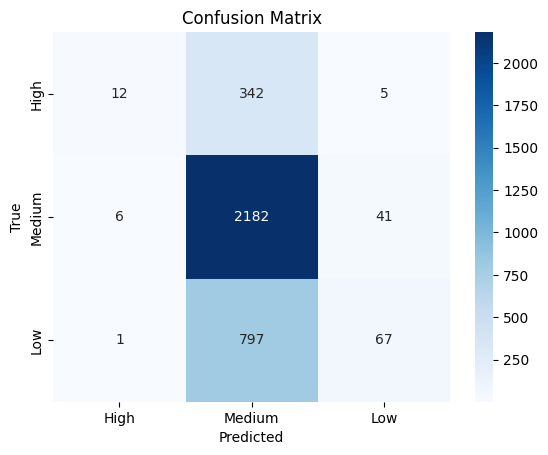

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Re-predict and evaluate
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["High", "Medium", "Low"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["High", "Medium", "Low"], yticklabels=["High", "Medium", "Low"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **Using GridSearchCV to Find the Best Hyperparameters**


**Grid Search on LinearSVC**

In [43]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define model with class balancing
svc = LinearSVC(class_weight='balanced', max_iter=5000)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10]  # regularization strength
}

# Wrap in GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit on training vectors (optionally SMOTE balanced)
grid_search.fit(X_train_vec, y_train)

# Best model
best_svc = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_svc.predict(X_test_vec)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 0.1}
              precision    recall  f1-score   support

        High       0.28      0.25      0.27       359
         Low       0.48      0.37      0.42       865
      Medium       0.70      0.78      0.74      2229

    accuracy                           0.62      3453
   macro avg       0.49      0.47      0.47      3453
weighted avg       0.60      0.62      0.61      3453



In [44]:
import joblib

joblib.dump(model, "priority_classifier_final.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_final.pkl")

['tfidf_vectorizer_final.pkl']

# **Data Visualization**

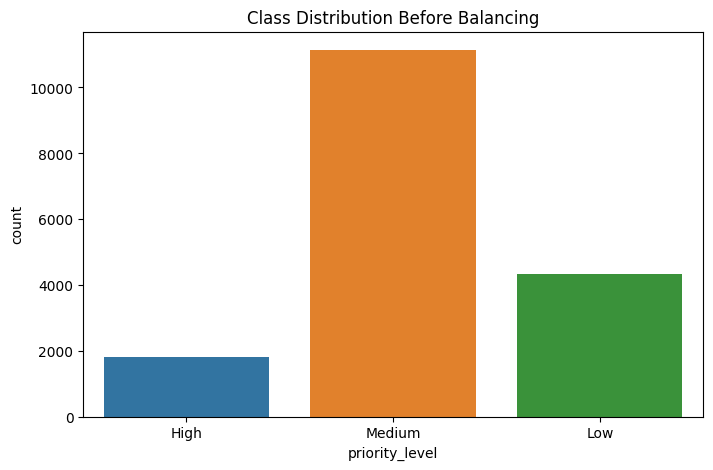

In [45]:
# Class Distribution Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='priority_level', data=df, order=["High", "Medium", "Low"])
plt.title('Class Distribution Before Balancing')
plt.show()

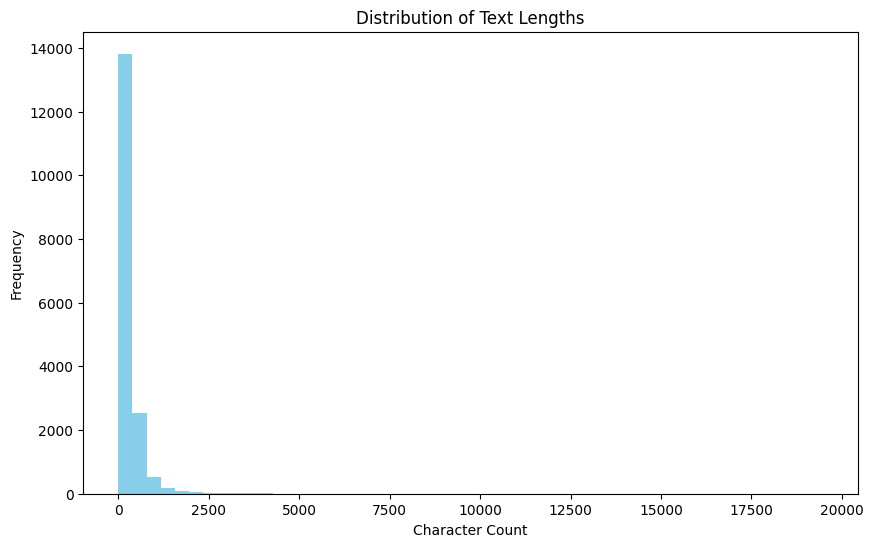

In [46]:
# Text Length Distribution
df['text_length'] = df['input_text'].apply(len)
plt.figure(figsize=(10,6))
plt.hist(df['text_length'], bins=50, color='skyblue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

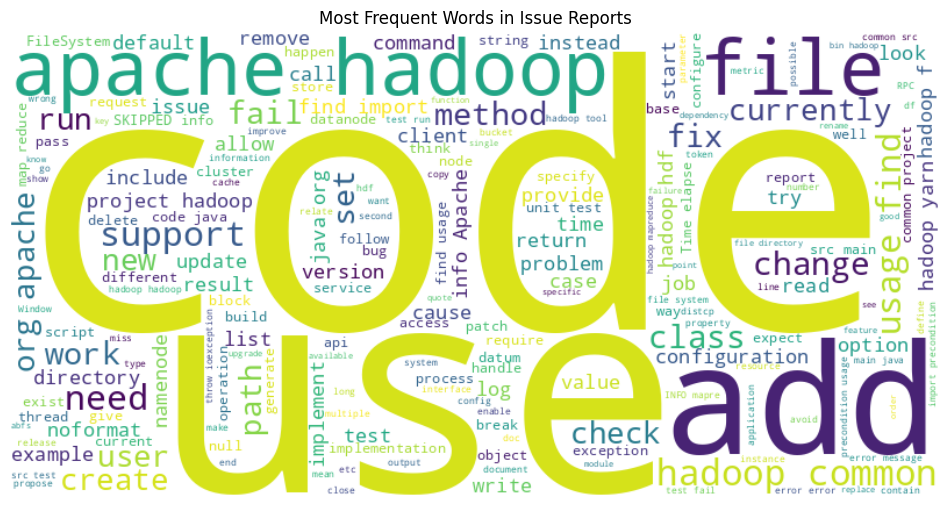

In [47]:
# Word Cloud Visualization
from wordcloud import WordCloud

all_text = " ".join(df['input_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Issue Reports')
plt.show()

NameError: name 'y_train_bal' is not defined

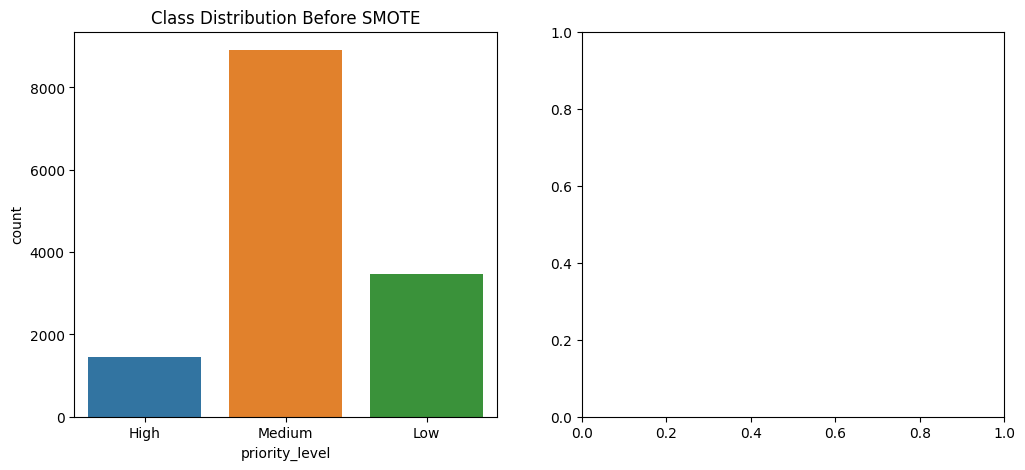

In [48]:
# Before/After SMOTE Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(x=y_train, ax=ax1, order=["High", "Medium", "Low"])
ax1.set_title('Class Distribution Before SMOTE')
sns.countplot(x=y_train_bal, ax=ax2, order=["High", "Medium", "Low"])
ax2.set_title('Class Distribution After SMOTE')
plt.tight_layout()
plt.show()

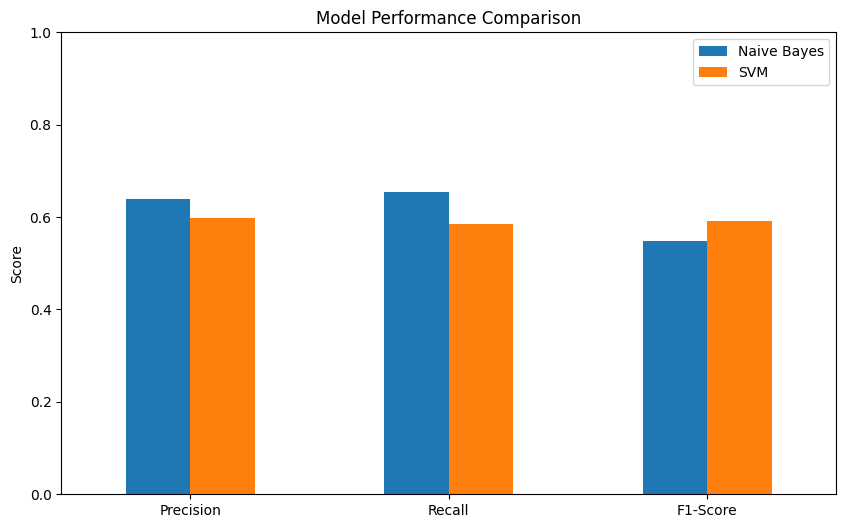

In [50]:
# Model Performance Comparison
nb_report = classification_report(y_test, model.predict(X_test_vec), output_dict=True)
svm_report = classification_report(y_test, svm_model.predict(X_test_vec), output_dict=True)

metrics_df = pd.DataFrame({
    'Naive Bayes': [nb_report['weighted avg']['precision'], 
    nb_report['weighted avg']['recall'], 
    nb_report['weighted avg']['f1-score']],
    'SVM': [svm_report['weighted avg']['precision'], 
    svm_report['weighted avg']['recall'], 
    svm_report['weighted avg']['f1-score']]
}, index=['Precision', 'Recall', 'F1-Score'])

metrics_df.plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


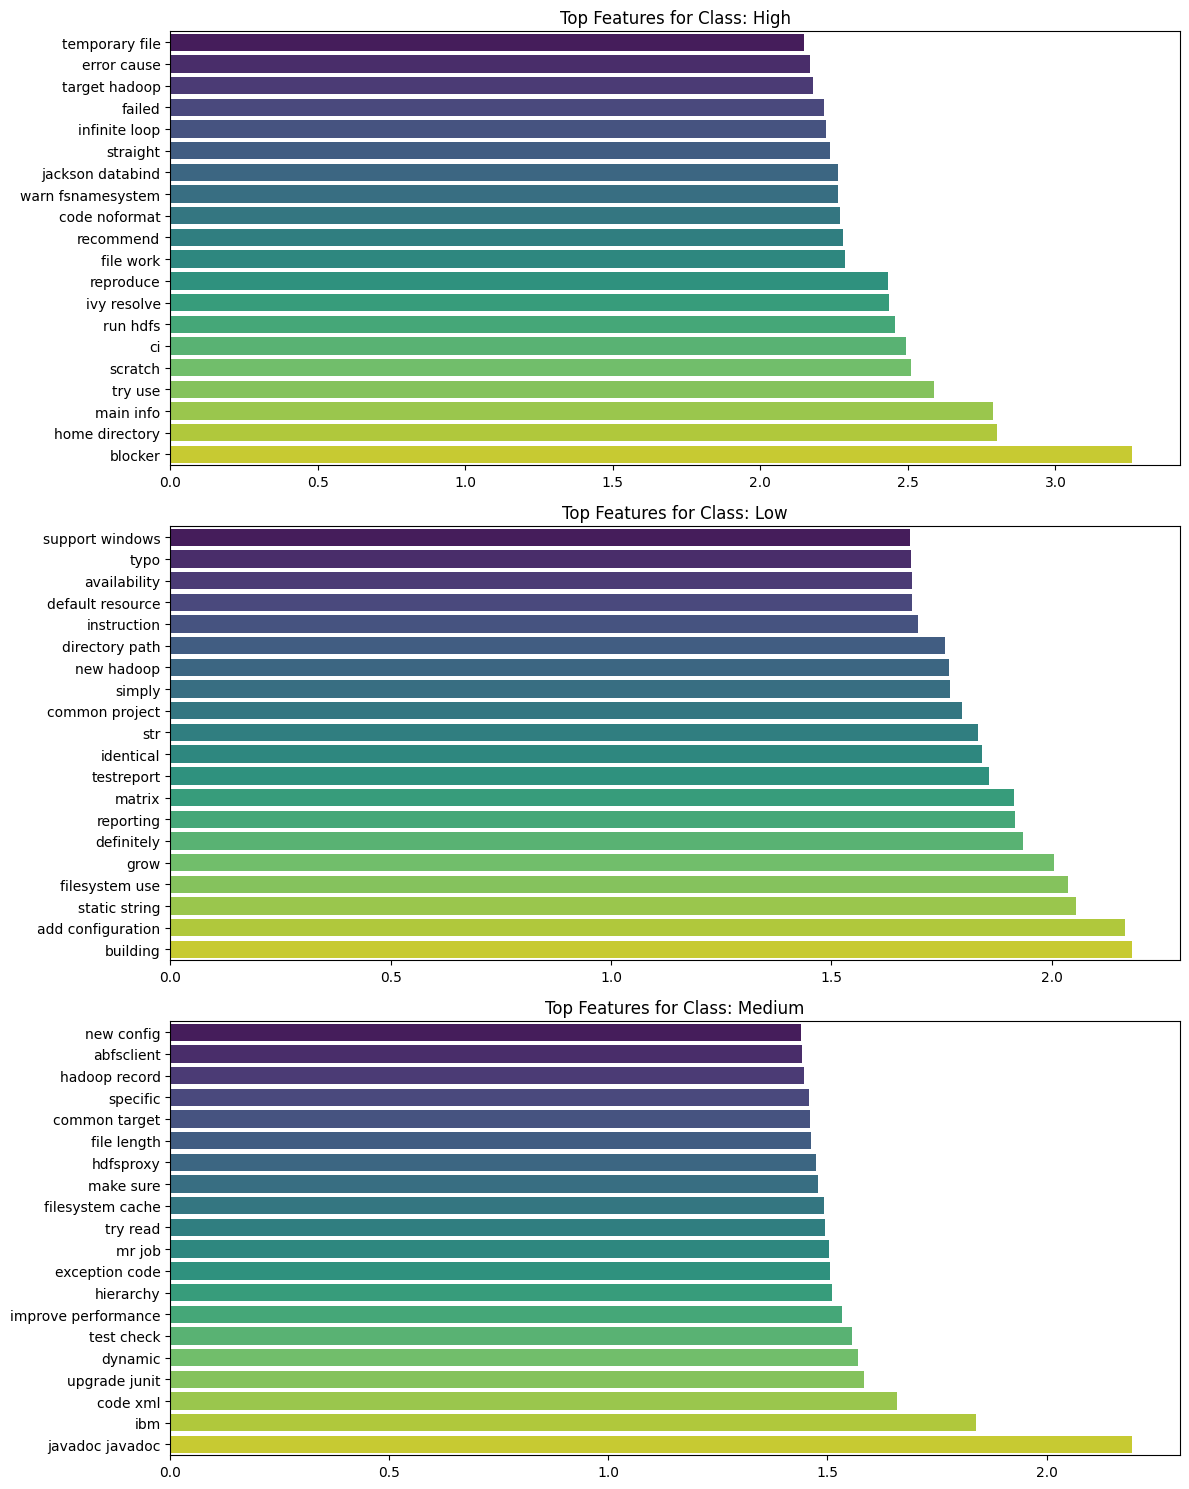

In [52]:
# Feature Importance Visualization

import numpy as np

def plot_top_features(model, vectorizer, n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    classes = model.classes_
    
    for i, cls in enumerate(classes):
        top_indices = np.argsort(coefficients[i])[-n:]
        top_features = [feature_names[j] for j in top_indices]
        scores = coefficients[i][top_indices]
        
        sns.barplot(x=scores, y=top_features, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Top Features for Class: {cls}')
    
    plt.tight_layout()
    plt.show()

plot_top_features(svm_model, vectorizer)

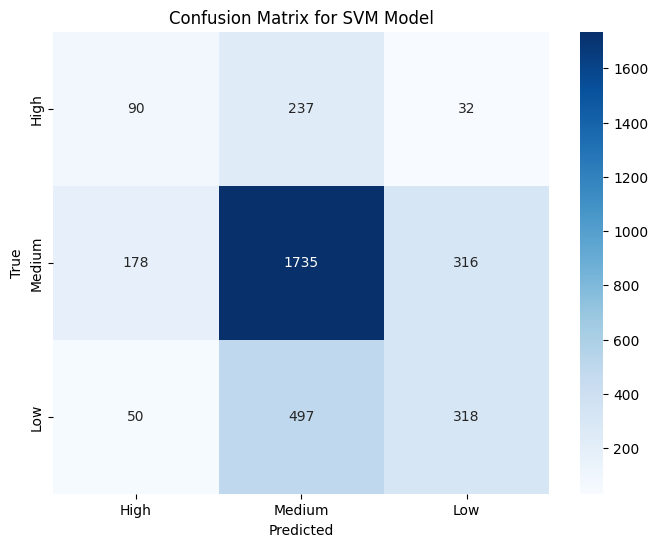

In [53]:
# Enhanced Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["High", "Medium", "Low"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["High", "Medium", "Low"], 
            yticklabels=["High", "Medium", "Low"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM Model")
plt.show()